# Machine Learning for Medicine - TP 8
## Data Integration with Deep Learning

In [25]:
import pandas as pd
from striprtf.striprtf import rtf_to_text
from io import StringIO

import numpy as np
import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Input, Dense
from keras.utils.np_utils import to_categorical as keras_tocat
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, ClassifierMixin

### Data

568


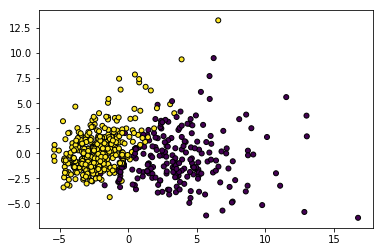

In [116]:
# Breast cancer
X = pd.read_csv('data/Breast.txt',sep=' ')
Y4 = X.values[:,30]==1 # Classes
X4 = X.values[:,0:29] # Observations
print(len(Y4))

X4_pca = PCA(n_components=3).fit_transform(X4)
plt.scatter(X4_pca[:, 0], X4_pca[:, 1], s=25, c=Y4, marker='o', edgecolors='k')
plt.show()

71


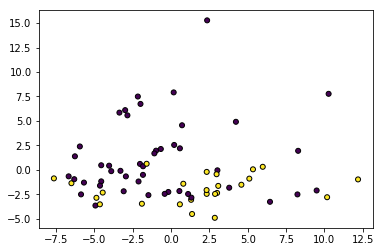

In [117]:
# Golub
X6 = pd.read_csv('data/Golub_X',sep=' ').values # Observations
Y6 = pd.read_csv('data/Golub_y',sep=' ')['0'] # Classes
print(len(Y6))

X6_pca = PCA(n_components=3).fit_transform(X6)
plt.scatter(X6_pca[:, 0], X6_pca[:, 1], s=25, c=Y6, marker='o', edgecolors='k')
plt.show()

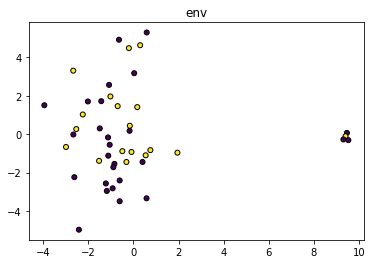

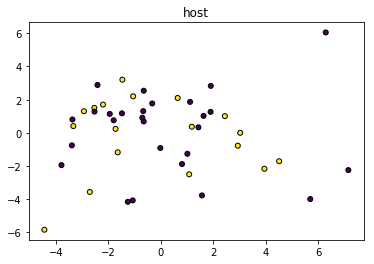

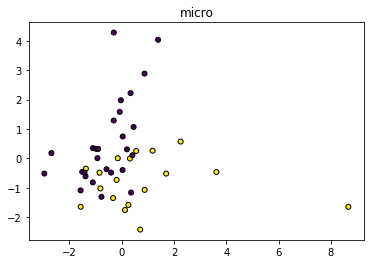

45


(0, 0)

In [130]:
# Micr-Obes

ds_env   = pd.read_csv('data/SPLEX_env.txt',   sep=' ', dtype='float32')
ds_host  = pd.read_csv('data/SPLEX_host.txt',  sep=' ', dtype='float32')
ds_micro = pd.read_csv('data/SPLEX_micro.txt', sep=' ', dtype='float32')
columns_env   = list(ds_env  .columns)
columns_host  = list(ds_host .columns)
columns_micro = list(ds_micro.columns)

X7_env   = StandardScaler().fit_transform(ds_env  )
X7_host  = StandardScaler().fit_transform(ds_host )
X7_micro = StandardScaler().fit_transform(ds_micro)

txt_Y7 = rtf_to_text(open('data/classes.rtf','r').read())
Y7 = pd.read_csv(StringIO(txt_Y7), dtype='category').Gene_count#.cat.codes

## remove where label is nan
X7_env   = X7_env  [~Y7.isna()]
X7_host  = X7_host [~Y7.isna()]
X7_micro = X7_micro[~Y7.isna()]
Y7       = Y7      [~Y7.isna()].cat.codes.astype('int64').values
X7 = np.concatenate([X7_env, X7_host, X7_micro], axis=1)


plt.title("env")
X7_pca = PCA(n_components=3).fit_transform(X7_env)
plt.scatter(X7_pca[:, 0], X7_pca[:, 1], s=25, c=Y7, marker='o', edgecolors='k')
plt.show()
plt.title("host")
X7_pca = PCA(n_components=3).fit_transform(X7_host)
plt.scatter(X7_pca[:, 0], X7_pca[:, 1], s=25, c=Y7, marker='o', edgecolors='k')
plt.show()
plt.title("micro")
X7_pca = PCA(n_components=3).fit_transform(X7_micro)
plt.scatter(X7_pca[:, 0], X7_pca[:, 1], s=25, c=Y7, marker='o', edgecolors='k')
plt.show()

print(len(Y7))
(X7!=X7).sum(), (Y7!=Y7).sum()


### K-Folds crossval

In [144]:
from sklearn.model_selection import KFold

## computes the k-folds precision score :

def score_kfolds(data, labels, clf, transformer=None, folds=20, random_state=None):
    rs = KFold(n_splits=folds, random_state=random_state, shuffle=True)
    scores = []
    for train_idx, test_idx in rs.split(data):
        x_train, y_train = data[train_idx], labels[train_idx]
        x_test,  y_test  = data[ test_idx], labels[ test_idx]
#         print(train_idx, len(train_idx))
#         print(y_train)
#         print(labels)
#         print(data.dtype, labels.dtype)    
        if transformer is not None:
            tr = transformer.fit(x_train, y_train)
            x_train = tr.transform(x_train)
            x_test  = tr.transform(x_test)
#         print((x_train!=x_train).sum(), (y_train!=y_train).sum())
        clf = clf.fit(x_train, y_train)
        sc = clf.score(x_test, y_test)
        scores.append(sc)
    return np.mean(scores)


### Keras model

In [145]:
def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'): 
            layer.kernel.initializer.run(session=session)
        if hasattr(layer, 'bias_initializer'):
            layer.bias.initializer.run(session=session)     

class KerasClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, inDim, outDim=2, layers=[32], batch_size=100, epochs=10, verbose=0, * args, **kwargs):
        super().__init__(*args, **kwargs)
        self.batch_size = batch_size
        self.epochs = epochs
        self.verbose = verbose
        ## model :
        self.model = Sequential()
        for l_size in layers:
            self.model.add(Dense(l_size, activation='relu', input_dim=inDim))
            inDim = l_size
        self.model.add(Dense(outDim, activation='softmax', input_dim=inDim))
        self.model.compile(
            optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        self.history_ = None
        
        
    def fit(self, XTrain, yTrain):
        reset_weights(self.model)
        self.history_ = self.model.fit(XTrain, keras_tocat(yTrain),
            batch_size=self.batch_size,
            epochs=self.epochs,
            verbose=self.verbose,
            validation_split=0.1)
        return self

    def predict_probas(self, XTest):
        return self.model.predict(XTest)
    def predict(self, XTest):
        return np.argmax(self.predict_probas(XTest), axis=1)
    
# ### TEST ###
# clf = KerasClassifier(X4.shape[1], verbose=0)
# clf.fit(X4, Y4)
# score = clf.model.evaluate(
#     X4, keras.utils.np_utils.to_categorical(Y4),
#    verbose=1)
# print('clf.model.evaluate : ', score[1])
# print('cld.score : ', clf.score(X4, Y4))

### Experiments
#### Breast cancer

In [152]:
data, labels = X4, Y4

folds = 10
clf = MLPClassifier(solver='lbfgs', alpha=1e-7, hidden_layer_sizes=(32,32),)
s = score_kfolds(data, labels, clf, folds=folds, random_state=12)
print('MLPClassifier score',folds,'folds : ', s)
clf2 = KerasClassifier(data.shape[1], layers=(32,32), batch_size=200, epochs=40)
s = score_kfolds(data, labels, clf2, folds=folds, random_state=12)
print('KerasClassifier score',folds,'folds : ', s)


MLPClassifier score 10 folds :  0.9594611528822055
KerasClassifier score 10 folds :  0.9824248120300751


>> Sur Breast Cancer, on observe que le modele keras performe légèrement mieux que MLPClassifier.
On n'observe pas d'overfitting, même en augmentant le nombre d'epochs.

#### Golub

In [147]:
data, labels = X6, Y6

folds = 3
clf = MLPClassifier(solver='lbfgs', alpha=1e-7, hidden_layer_sizes=(32,32),)
s = score_kfolds(data, labels, clf, folds=folds, random_state=12)
print('MLPClassifier score',folds,'folds : ', s)

clf2 = KerasClassifier(data.shape[1], layers=(32,32), batch_size=200, epochs=20)
s = score_kfolds(data, labels, clf2, folds=folds, random_state=12)
print('KerasClassifier score',folds,'folds : ', s)


MLPClassifier score 3 folds :  0.9293478260869565
KerasClassifier score 3 folds :  0.8031400966183576


>> Sur Golub en revanche le modèle keras overfit très facilement, ce que ne fait pas MLPClassifier

#### Micr-Obes
##### environment data

In [153]:
data, labels = X7_env, Y7

folds = 3
clf = MLPClassifier(solver='lbfgs', alpha=1e-7, hidden_layer_sizes=(32,32),)
s = score_kfolds(data, labels, clf, folds=folds, random_state=12)
print('MLPClassifier score',folds,'folds : ', s)

clf2 = KerasClassifier(data.shape[1], layers=(32,32), batch_size=200, epochs=20)
s = score_kfolds(data, labels, clf2, folds=folds, random_state=12)
print('KerasClassifier score',folds,'folds : ', s)


MLPClassifier score 3 folds :  0.48888888888888893
KerasClassifier score 3 folds :  0.5333333333333333


##### host data

In [154]:
data, labels = X7_host, Y7

folds = 3
clf = MLPClassifier(solver='lbfgs', alpha=1e-7, hidden_layer_sizes=(32,32),)
s = score_kfolds(data, labels, clf, folds=folds, random_state=12)
print('MLPClassifier score',folds,'folds : ', s)

clf2 = KerasClassifier(data.shape[1], layers=(32,32), batch_size=200, epochs=20)
s = score_kfolds(data, labels, clf2, folds=folds, random_state=12)
print('KerasClassifier score',folds,'folds : ', s)


MLPClassifier score 3 folds :  0.4000000000000001
KerasClassifier score 3 folds :  0.4444444444444445


##### microbiota data

In [155]:
data, labels = X7_micro, Y7

folds = 3
clf = MLPClassifier(solver='lbfgs', alpha=1e-7, hidden_layer_sizes=(32,32),)
s = score_kfolds(data, labels, clf, folds=folds, random_state=12)
print('MLPClassifier score',folds,'folds : ', s)

clf2 = KerasClassifier(data.shape[1], layers=(32,32), batch_size=200, epochs=20)
s = score_kfolds(data, labels, clf2, folds=folds, random_state=12)
print('KerasClassifier score',folds,'folds : ', s)


MLPClassifier score 3 folds :  0.9777777777777779
KerasClassifier score 3 folds :  0.8000000000000002


##### environment + host + microbiota data

In [156]:
data, labels = X7, Y7

folds = 3
clf = MLPClassifier(solver='lbfgs', alpha=1e-7, hidden_layer_sizes=(32,32),)
s = score_kfolds(data, labels, clf, folds=folds, random_state=12)
print('MLPClassifier score',folds,'folds : ', s)

clf2 = KerasClassifier(data.shape[1], layers=(32,32), batch_size=200, epochs=20)
s = score_kfolds(data, labels, clf2, folds=folds, random_state=12)
print('KerasClassifier score',folds,'folds : ', s)


MLPClassifier score 3 folds :  0.7111111111111111
KerasClassifier score 3 folds :  0.5111111111111111


>> On observe que le meilleur modèle est le MLPClassifier sur les données microbiota, suivi par KerasClassifier sur microbiota aussi. 
La concaténation des 3 datasets ajoute plus de bruit que d'informations.